In [1]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import scipy
import numpy as np
import astropy.units as u
from lightkurve import search_targetpixelfile

import starry

import pymc3 as pm
import pymc3_ext as pmx
import exoplanet

starry.config.quiet = True
starry.config.lazy = True

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# DI Herculis system:

DI Herculis is a well-known eclipsing binary system with two B-type components and is described in [this paper](https://arxiv.org/abs/2201.1169). 

There are spots in the TESS light curve with unknown origin and extent. I would like to know if it is possible to solve for the map of these spots along with the gravity darkening signature and obliquities of each star. 

This notebook will have the following sections:

- Downloading the light curve from TESS
- Coming up with priors for the model
- Constructing the model
- Solving for all parameters

## Downloading the light curve from TESS:

There is now data in both Sector 26 and in Sector 40, but only the Sector 26 has an SPOC light curve. I use PLDCorrector in lightkurve to create a light curve for Sector 40 data.

In [2]:
search_result = lk.search.search_tesscut(target='DI Her')[0:2]
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 26,2020,TESScut,1426,DI Her,0.0
1,TESS Sector 40,2021,TESScut,475,DI Her,0.0


In [3]:
lcflist = lk.search_lightcurvefile('DI Her')

C:\Users\ryanw\AppData\Local\Temp\ipykernel_4052\2552183542.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lcflist = lk.search_lightcurvefile('DI Her')


In [4]:
spoc = lcflist[0].download()

In [5]:
tpf = search_result.download_all(cutout_size=50)

16


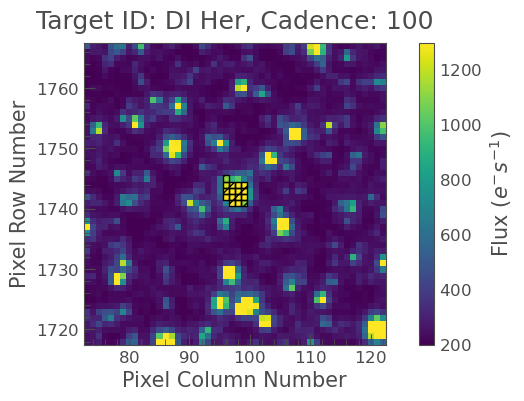

In [6]:
target_masks = []
pixels = []
tpfs = []
for tp in tpf[1:]:
    target_mask = tp.create_threshold_mask(threshold=15, reference_pixel='center')
    target_masks.append(target_mask)
    n_target_pixels = target_mask.sum()
    pixels.append(n_target_pixels)
    print(n_target_pixels)
    tpfs.append(tp)
    tp.plot(aperture_mask=target_mask, mask_color='k',cadenceno=100);

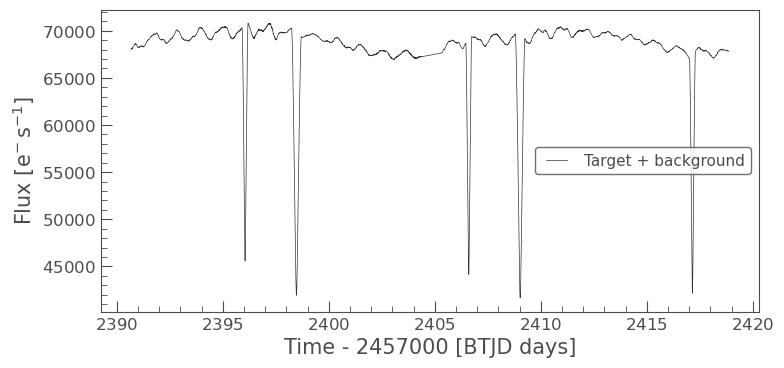

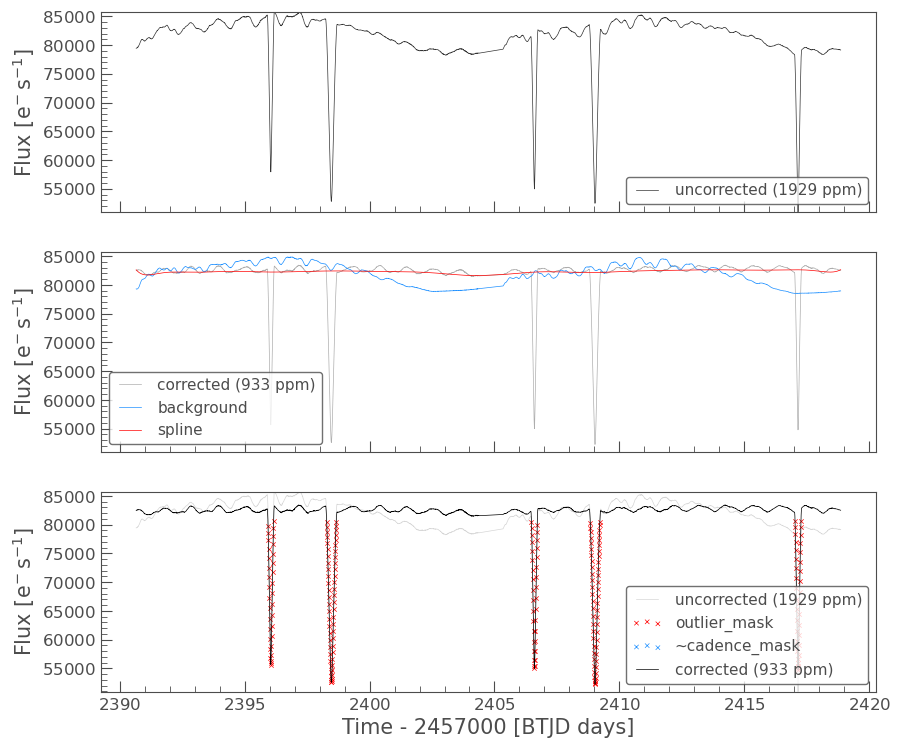

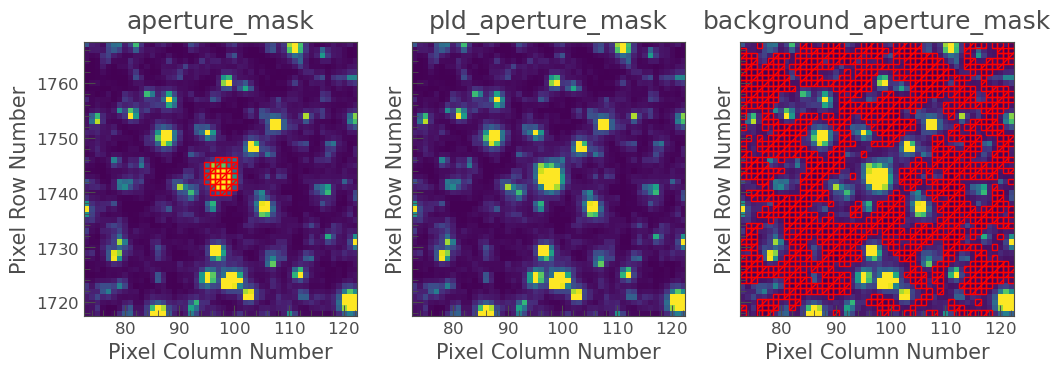

In [7]:
%matplotlib inline
from lightkurve.correctors import PLDCorrector


target_lcs = []
for i,v in enumerate(tpfs):
    uncorr_lc = v.to_lightcurve(aperture_mask=target_masks[i])
    uncorr_lc = uncorr_lc.remove_nans()
    uncorr_lc.plot(label='Target + background');

    pld = PLDCorrector(v)
    target_lcs.append(pld.correct(spline_n_knots=21))
    pld.diagnose();
    pld.diagnose_masks();

<IPython.core.display.Javascript object>


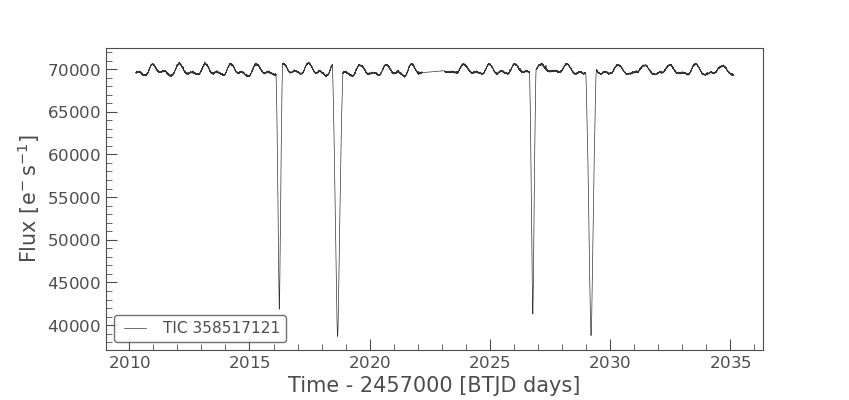

<IPython.core.display.Javascript object>


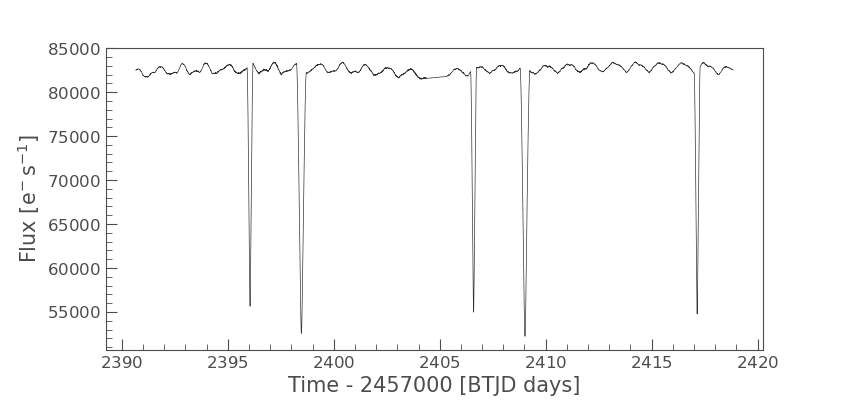

In [8]:
%matplotlib notebook
spoc.plot()
for corr_lc in target_lcs:
    corr_lc.plot()

## Model system:

Let's make a by-eye model fit of the eclipses to see if we can get close using the parameters from Liang et al. 2022:

In [9]:
#create spherical star system presented in Gaudi et al. 2017
pri_map = starry.Map(udeg=2, gdeg=4, oblate=True) #ydeg = 2*order_approx udeg=2
pri_map[1] = 0.10582983
pri_map[2] = 0.15800942

pri_map.omega=0.225
pri_map.beta = 0.08
pri_map.wav=786.5 #TESS center bandpass
pri_map.tpole=17300
pri_map.f = 1-2/(0.225**2 + 2)

pri = starry.Primary(pri_map, m=5.1010866, r=2.66545675,prot=1.07)
sec_map = starry.Map(udeg=2)

sec_map[1] = 0.10582983
sec_map[2] = 0.15800942
sec_map.amp=0.4261567900304972/0.550557973523685
sec = starry.kepler.Secondary(map=sec_map,
    m=4.4,  # mass in solar masses
    r=2.4639126,  # radius in solar radii
    porb=10.54980498,  # orbital period in days
    inc=88.90036682,
    Omega=90,  # longitude of ascending node in degrees
    ecc=0.50002386,  # eccentricity
    w=327.28591637,  # longitude of pericenter in degrees
    t0=2018.67830937,  # time of transit in days
)
sys = starry.System(pri, sec)

<IPython.core.display.Javascript object>


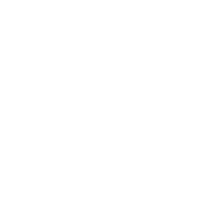

In [10]:
pri_map.show(theta=np.linspace(0, 360, 50))

In [11]:
pri.map.Ny

1

<IPython.core.display.Javascript object>


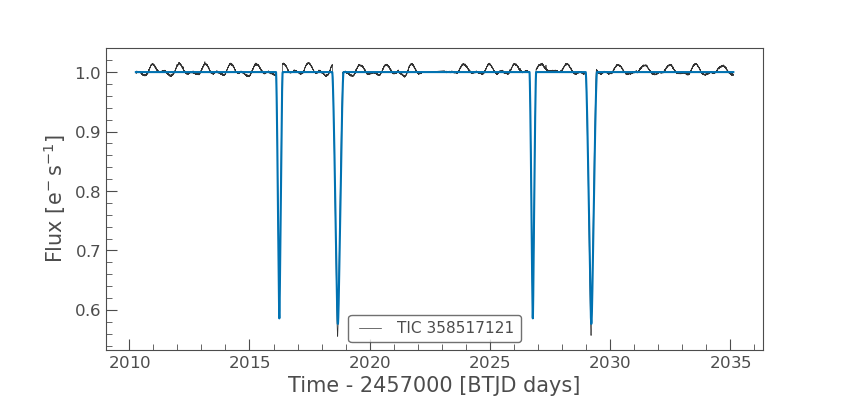

In [12]:
(spoc/np.median(spoc.flux.value)).plot()
time = spoc.time.value
model_flux = sys.flux(time).eval()
plt.plot(time, model_flux/np.median(model_flux));

In [13]:
np.median(model_flux)

1.77404526048911

## Priors:

We know the star has two components: a spotted primary and (most likely) a featureless secondary. Both stars are rapidly rotating and hence will have gravity darkening; it is uncertain whether oblateness is a very significant effect, but it will have to be negated due to not having an analytic model for oblateness of both objects in starry.

The rotation period of the primary is also known from the spot modulation, at least to a fair degree. The rotation period of the secondary is not known, and must be set as a uniform parameter in the fit. As such, the primary will not have an $\omega sin i_*$ but simply an $\omega$ with errors. The secondary will have an $\omega sin i$ and the rotation rate and gravity darkening map will be a function of the inclination. Both stars will also have free obliquities, which will not change the map coefficients themselves. The period, epoch, eccentricity and other parameters will be taken from the linked paper above. 

In [14]:
#primary limb darkening
u1_m = 0.124
u1_e = 0.1
u2_m = 0.262 
u2_e = 0.1


#primary mass and radius
A_m_m = 5.1
A_m_e = 0.2
A_r_m = 2.4
A_r_e = 0.3

#primary rot period and tpole
A_prot_m =  1.07 #in days
A_omega = 0.225 #dimensionless
A_prot_e = 0.1

A_tpole_m = 17300
A_tpole_e = 800

#secondary luminosity ratio
B_amp_l = 0.6
B_amp_u = 0.8
#secondary mass and radius
B_m_m = 4.4
B_m_e = 0.2
B_r_m = 2.5
B_r_e = 0.3

#secondary tpole
B_tpole_m = 15400
B_tpole_e = 800

#secondary vsini
B_vsini_m = 100
B_vsini_e = 30

#orbital parameters
orb_inc_m = 89.02
orb_inc_e = 1.0


G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8

## Creating the model:

In [15]:
import theano.tensor as tt

time = spoc.time.value
flux = spoc.flux.value/np.median(spoc.flux.value)
ferr = spoc.flux_err.value/np.median(spoc.flux.value)

with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    BoundedNormal = pm.Bound(pm.Normal, lower=0)
    
    A_m = BoundedNormal("A_M",mu=A_m_m,sd=A_m_e,testval=A_m_m)
    A_r = BoundedNormal("A_R",mu=A_r_m,sd=A_r_e,testval=A_r_m)
    A_inc_rad = pmx.Periodic("A inc", lower=0, upper=np.pi/2)
    A_inc = pm.Deterministic("A inc deg", A_inc_rad*180/np.pi)
    A_prot = BoundedNormal("A_prot",mu=1.07,sd=0.1,testval=1.07)
    
    pm.Potential("isotropy", tt.log(tt.sin(A_inc_rad)))
    
    u1 = BoundedNormal("u1",mu=u1_m,sd=u1_e, testval=u1_m+0.001)
    u2 = BoundedNormal("u2",mu=u2_m,sd=u2_e,testval=u2_m-0.001)
    
    
    pri_map = starry.Map(udeg=2,ydeg=4, gdeg=4, oblate=True, normalized=True) #ydeg = 2*order_approx udeg=2
    
    pri_map.omega = A_omega
    pri_map.beta = 0.08
    pri_map.wav = 786.5 #TESS center bandpass
    pri_map.tpole= A_tpole_m
    pri_map.f = (1-2/(A_omega**2 + 2))
    
    pri_map[1] = u1
    pri_map[2] = u2
    pri_map.inc= A_inc
    pri_map.obl = pm.Uniform("A obl", lower=80, upper=120, testval=90)

    primary = starry.Primary(pri_map, m=A_m, r=A_r,prot=A_prot)

    #spin orbit parameters
    #pm.Deterministic("inc planet", orbit.incl*180/np.pi)
    #pm.Deterministic("true spin orbit", tt.arccos(tt.cos(orbit.incl)*tt.cos(inc_s)
                                              # + tt.sin(inc_s)*tt.cos(omega_p)*tt.sin(orbit.incl))*180/np.pi)
 
    B_r = BoundedNormal("B_R",mu=B_r_m,sd=B_r_e,testval=B_r_m)
    #omega_p = pmx.Angle("Omega")
    #lambda_p = pm.Deterministic("lambda", omega_p*180/np.pi) #the projected obliquity in degrees

    sec_map = starry.Map(udeg=2,ydeg=2)
    sec_map[1] = u1
    sec_map[2] = u2
    secondary = starry.kepler.Secondary(map=sec_map,
        m=4.4,  # mass in solar masses
        r=B_r,  # radius in solar radii
        porb=BoundedNormal("period",mu=10.55004,sd=0.001, testval=10.55004),  # orbital period in days
        inc=pm.Uniform("inc orb",lower=88.90,upper=89.8, testval=89.02),
        Omega=0,  # longitude of ascending node in degrees, assume pole on
        ecc=pm.Uniform("ecc", lower=0.50, upper=0.51, testval=0.505),  # eccentricity
        w=pm.Uniform("long periastron",lower=320.6,upper=330.6, testval=326.5),  # longitude of pericenter in degrees
        t0=pm.Uniform("t0", lower=2018.4681, upper=2018.8681, testval=2018.6681),  # time of transit in days
    )
    
    system = starry.System(primary, secondary)
    
    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    #pm.Normal("obs", flux_model, sd=tt.sqrt(tt.exp(log_sigma_lc)**2), observed=flux)

In [16]:
with model:
    system.set_data(flux, C=ferr**2)

    # Prior on primary
    pri_mu = np.zeros(primary.map.Ny)
    pri_mu[0] = 0.550557973523685
    pri_L = np.zeros(primary.map.Ny)
    pri_L[0] = 1e-2
    pri_L[1:] = 1e-2
    primary.map.set_prior(mu=pri_mu, L=pri_L)
    
    # Prior on secondary
    sec_mu = np.zeros(secondary.map.Ny)
    sec_mu[0] = 0.4261567900304972
    sec_L = np.zeros(secondary.map.Ny)
    sec_L[0] = 1e-4
    sec_L[1:] = 1e-4
    secondary.map.set_prior(mu=sec_mu, L=sec_L)


    pm.Potential("marginal", system.lnlike(t=time))

In [17]:
with model:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000001C7B28BAEE0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000001C7B28BAEE0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [t0, long periastron, ecc, inc orb, period, B_R, A obl, u2, u1, A_prot, A inc, A_R, A_M]


message: Desired error not necessarily achieved due to precision loss.
logp: -63400.85040728369 -> 21031.51104489985


In [45]:
with model:
    x = pmx.eval_in_model(system.solve(t=time)[0], point=map_soln)
    primary.map.amp = x[0]
    primary.map[1:, :] = x[1:primary.map.Ny] / primary.map.amp
    secondary.map.amp = x[primary.map.Ny]
    secondary.map[1:, :] = x[primary.map.Ny + 1:] / secondary.map.amp
    primary2 = starry.Primary(primary.map, m=map_soln["A_M"], r=map_soln["A_R"], prot=map_soln["A_prot"])
    secondary2 = starry.Secondary(map=secondary.map, m=4.4, r=map_soln["B_R"], porb=map_soln["period"],
        inc=map_soln["inc orb"], Omega=0, ecc=map_soln["ecc"], w=map_soln["long periastron"], t0=map_soln["t0"])
    system2 = starry.System(primary2, secondary2)
    system2.set_data(flux, C=ferr**2)
    flux_model = pmx.eval_in_model(system2.flux(t=time), point=map_soln)

In [41]:
map_soln

{'A_M_lowerbound__': array(1.6297321),
 'A_R_lowerbound__': array(0.91640871),
 'A inc_periodic__': array([ 3.43627802, -2.86227052]),
 'A_prot_lowerbound__': array(0.07244591),
 'u1_lowerbound__': array(-1.62036534),
 'u2_lowerbound__': array(-6.51019399),
 'A obl_interval__': array(0.98268014),
 'B_R_lowerbound__': array(0.95717564),
 'period_lowerbound__': array(2.35609367),
 'inc orb_interval__': array(-7.57915835),
 'ecc_interval__': array(-6.84814588),
 'long periastron_interval__': array(0.68399051),
 't0_interval__': array(0.11024205),
 'A_M': array(5.10250755),
 'A_R': array(2.50029497),
 'A inc': array(1.35172622),
 'A inc deg': array(77.44820763),
 'A_prot': array(1.07513465),
 'u1': array(0.19782641),
 'u2': array(0.00148819),
 'A obl': array(109.10558766),
 'B_R': array(2.60433052),
 'period': array(10.54966042),
 'inc orb': array(88.90045966),
 'ecc': array(0.5000106),
 'long periastron': array(327.24628755),
 't0': array(2018.67911305)}

In [ ]:
with model:
    a = pmx.eval_in_model(system2.flux(t=time), point=map_soln)
a = a / np.median(a)

In [ ]:
primary.map.amp = 0.5275681785646107

<IPython.core.display.Javascript object>


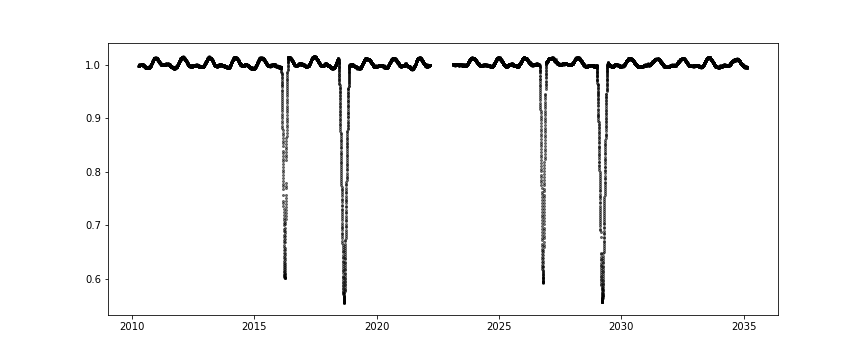

TypeError: object of type 'TensorVariable' has no len()

In [53]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(time, flux, "k.", alpha=0.5, ms=4, label="data")
ax.plot(time, flux_model, "C0", label="MAP")
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24)
ax.legend();

In [ ]:
fig, (ax, ax2) = plt.subplots(2, figsize=(12, 5), sharex=True,)
ax.plot(time, flux, "k.", alpha=0.5, ms=4, label="data")
ax.plot(time, flux_model, "C0", label="MAP")
ax2.plot(time, (flux)-flux_model, "C0", label="Residual")
ax.set_xlabel("time [days]", fontsize=24)
ax.legend();

In [ ]:
x[0]+x[primary.map.]

In [ ]:
gdeg = map._f.eval()

In [ ]:
map = starry.Map(ydeg=4)


map.inc = map_soln["A inc deg"]
map.obl = map_soln["A obl"]
map.amp = x[0]
map[1:, :] =  gdeg[1:]*(x[1 : primary.map.Ny]) / map.amp
map.show(theta=np.linspace(0, 360, 50))

In [ ]:
map.amp.eval()

In [ ]:
5.82960417-

In [ ]:
map.amp.eval()-x[0]

In [ ]:
map = starry.Map(ydeg=4,udeg=2)
len(map.y.eval())

In [ ]:
map = starry.Map(ydeg=2)
map.inc = 90
map.amp = x[primary.map.Ny]
map[1:, :] = x[primary.map.Ny + 1 :] / map.amp
map.show(theta=np.linspace(0, 360, 50))

In [ ]:
map = starry.Map(udeg=2,ydeg=4)
map.inc = map_soln["A inc deg"]
map.amp = x[0]
map[1:, :] = gdeg[1:]*x[1 : primary.map.Ny] / map.amp
map[1] = map_soln['u1']
map[2] = map_soln['u2']

map.show(theta=np.linspace(0, 360, 50))

In [ ]:
map = starry.Map(udeg=2,ydeg=1)
map.inc = 90
map[1] = map_soln['u1']
map[2] = map_soln['u2']
map.amp = x[primary.map.Ny]
map[1:, :] = x[primary.map.Ny + 1 :] / map.amp
map.show(theta=np.linspace(0, 360, 50))

In [ ]:
map = starry.Map(gdeg=4, oblate=True) #ydeg = 2*order_approx udeg=2

map.omega=0.225
map.beta = 0.08
map.wav=786.5 #TESS center bandpass
map.tpole=17300
map.f = 1-2/(0.225**2 + 2)

map.amp = 1.0
print(map.amp.eval())

In [ ]:
map.amp.eval()